In [4]:
#import libraries
import numpy as np
import tensorflow as tf

import os
import sys
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import scipy.io
import scipy.misc

from nstmod import *

In [5]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

#get the content image
base_img = scipy.misc.imread("images/cat.jpg")
base_img = np.reshape(base_img, ((1,) + base_img.shape))
base_img = base_img - DATA.MEANS

#get the style image
style_img = scipy.misc.imread("images/holi_colour.jpg")
style_img = np.reshape(style_img, ((1,) + style_img.shape))
style_img = style_img - DATA.MEANS

#randomly initializing the image to be generated
noise_ratio = DATA.NOISE_RATIO
noise_img = np.random.uniform(-20, 20, (1, DATA.IMAGE_HEIGHT, DATA.IMAGE_WIDTH, DATA.COLOR_CHANNELS)).astype('float32')
new_img = noise_img * noise_ratio + base_img * (1 - noise_ratio)

In [6]:
model = vgg_m("imagenet-vgg-verydeep-19.mat")

#Run the content image and style omage through the VGG19 model and cal total cost
def cal_layer_style_cost(aS, aG):
    m, n_H, n_W, n_C = aG.get_shape().as_list()
    aS = tf.transpose(tf.reshape(aS, shape=[-1, n_C]))
    aG = tf.transpose(tf.reshape(aG, shape=[-1, n_C]))
    GS = tf.matmul(aS, aS, transpose_b=True)
    GG = tf.matmul(aG, aG, transpose_b=True)
    J_style_layer = 1 / (2*n_C*n_H*n_W)**2 * tf.reduce_sum((GS-GG)**2)
    return J_style_layer

STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

def cal_style_cost(model, STYLE_LAYERS):
    J_style = 0
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        aS = sess.run(out)
        aG = out
        J_style_layer = cal_layer_style_cost(aS, aG)
        J_style += coeff * J_style_layer
    return J_style

sess.run(model['input'].assign(base_img))
out = model['conv4_2']
aS = sess.run(out)
aG = out

m, n_H, n_W, n_C = aG.get_shape().as_list()
J_base = 1 / (4 * n_H * n_W * n_C) * tf.reduce_sum((aS - aG)**2)

sess.run(model['input'].assign(style_img))

J_style = cal_style_cost(model, STYLE_LAYERS)
J = 10 * J_base + 40 * J_style

#optimizer and the learning rate
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(J)

In [10]:
def model_nn(sess, input_img, num_iterations = 300):
    sess.run(tf.global_variables_initializer())
    sess.run(model['input'].assign(input_img))
    
    #updating the generated image at every step.
    for i in range(num_iterations):
        sess.run(train_step)
        new_img = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_base, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("base cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            #new_img = new_img + DATA.MEANS
            #new_img = np.clip(new_img[0], 0, 255).astype('uint8')
            #scipy.misc.imsave("output/" + str(i) + ".png", new_img)
            
    new_img = new_img + DATA.MEANS
    new_img = np.clip(new_img[0], 0, 255).astype('uint8')
    scipy.misc.imsave("images/output/" + str(i) + ".png", new_img)
    return new_img

model_nn(sess, new_img)

Iteration 0 :
total cost = 3.56775e+10
base cost = 6492.42
style cost = 8.91935e+08
Iteration 20 :
total cost = 6.19649e+09
base cost = 25708.4
style cost = 1.54906e+08
Iteration 40 :
total cost = 2.39669e+09
base cost = 29158.9
style cost = 5.99099e+07
Iteration 60 :
total cost = 1.2209e+09
base cost = 30079.7
style cost = 3.0515e+07
Iteration 80 :
total cost = 7.73196e+08
base cost = 30541.7
style cost = 1.93223e+07
Iteration 100 :
total cost = 5.56855e+08
base cost = 30859.9
style cost = 1.39136e+07
Iteration 120 :
total cost = 4.30983e+08
base cost = 31131.8
style cost = 1.07668e+07
Iteration 140 :
total cost = 3.47959e+08
base cost = 31397.3
style cost = 8.69112e+06
Iteration 160 :
total cost = 2.9e+08
base cost = 31640.4
style cost = 7.24209e+06
Iteration 180 :
total cost = 2.47871e+08
base cost = 31841.7
style cost = 6.18882e+06
Iteration 200 :
total cost = 2.15946e+08
base cost = 32008.3
style cost = 5.39065e+06
Iteration 220 :
total cost = 1.90915e+08
base cost = 32147.5
style

array([[[174, 168, 212],
        [134, 128, 130],
        [118,  54,  74],
        ..., 
        [ 76, 232, 137],
        [118, 223, 173],
        [ 99, 255, 139]],

       [[157, 154, 172],
        [154, 113,  66],
        [133,  70,  71],
        ..., 
        [123, 180, 210],
        [119, 211, 164],
        [ 72, 167, 118]],

       [[182, 108, 102],
        [114,  97,  79],
        [100,  95,  84],
        ..., 
        [149, 166, 250],
        [153, 190, 211],
        [ 88, 141, 101]],

       ..., 
       [[ 66,  89, 156],
        [ 26,  48, 125],
        [ 26,  51,  95],
        ..., 
        [187, 164, 148],
        [200, 181, 115],
        [235, 182, 107]],

       [[  7,  44, 167],
        [ 15,   0,  70],
        [ 24,   0,  51],
        ..., 
        [208, 170, 110],
        [215, 187, 149],
        [230, 199, 124]],

       [[  0,  77, 168],
        [  0,   0, 150],
        [  2,   0, 142],
        ..., 
        [207, 186, 113],
        [244, 205, 130],
        [255, 207,

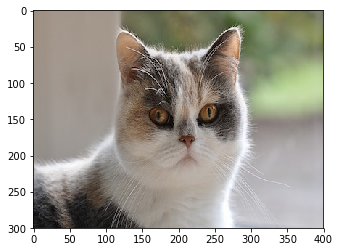

In [11]:
base_img = scipy.misc.imread("images/cat.jpg")
imshow(base_img)

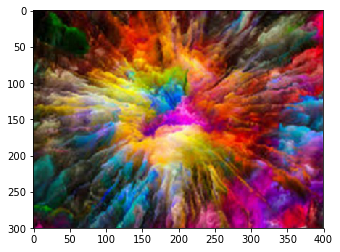

In [12]:
style_img = scipy.misc.imread("images/holi_colour.jpg")
imshow(style_img)

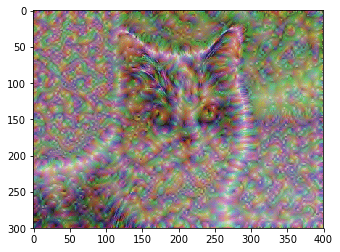

In [13]:
x= scipy.misc.imread("output/20.png")
imshow(x)

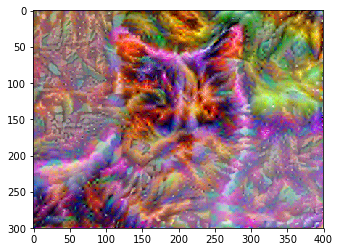

In [16]:
new_img = scipy.misc.imread("output/299.png")
imshow(new_img)